In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [15]:
cd /content/drive/MyDrive/Colab\ Notebooks

/content/drive/MyDrive/Colab Notebooks


In [3]:
import torch
import torchvision
import numpy as np
import tqdm
from torch import nn
from scipy.stats import rankdata
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from itertools import product

import matplotlib.pyplot as plt
from torchvision import datasets

from src.ex_1 import ActivationSwitch, LossSwitch, NeuralNetwork, compute_1d_power_spectrum, convert_str_to_activation_fn

activations = [
    ActivationSwitch.RELU,
    ActivationSwitch.SOFTPLUS_B1,
    ActivationSwitch.SOFTPLUS_B10,
    ActivationSwitch.SOFTPLUS_B100,
    ActivationSwitch.SOFTPLUS_B1000,
    ActivationSwitch.SOFTPLUS_B10000,
    # ActivationSwitch.SOFTPLUS_B100000,
    # LEAKY RELU
    ]
losses = [
    LossSwitch.CE,
    # LossSwitch.MSE
    ]

bias = "--no-bias"
batch_size = 64
lr = 1e-5
epochs = 10
img_size = 64
ckpt_mod = epochs - 1 # checkpoint if epoch % ckpt_mod == 0

In [4]:
# !mkdir checkpoints/
# !rm checkpoints/*
!ls checkpoints/*

checkpoints/RELU_CE_9_conv_False.pth		  checkpoints/SOFTPLUS_B100_CE_9_conv_False.pth
checkpoints/RELU_CE_9.pth			  checkpoints/SOFTPLUS_B10_CE_9_conv_False.pth
checkpoints/SOFTPLUS_B100000_CE_9_conv_False.pth  checkpoints/SOFTPLUS_B1_CE_9_conv_False.pth
checkpoints/SOFTPLUS_B10000_CE_9_conv_False.pth   checkpoints/SOFTPLUS_B1_CE_9.pth
checkpoints/SOFTPLUS_B1000_CE_9_conv_False.pth


In [6]:
for activation, loss in product(activations,losses):
    !python submission/training.py --ckpt_mod {ckpt_mod} {bias} --activation {activation} --loss {loss} --lr {lr} --epochs {epochs} --img_size {img_size} --batch_size {batch_size}

Experiment RELU CE bias False
Epoch 1
-------------------------------
loss: 0.256956: 100% 938/938 [00:20<00:00, 45.21it/s]
Test Error: 
 Accuracy: 89.1%, test loss: 0.252510 

Epoch 2
-------------------------------
loss: 0.100284: 100% 938/938 [00:19<00:00, 47.12it/s]
Test Error: 
 Accuracy: 90.0%, test loss: 0.229881 

Epoch 3
-------------------------------
loss: 0.188781: 100% 938/938 [00:20<00:00, 45.24it/s]
Test Error: 
 Accuracy: 91.3%, test loss: 0.212499 

Epoch 4
-------------------------------
loss: 0.195245: 100% 938/938 [00:19<00:00, 47.88it/s]
Test Error: 
 Accuracy: 91.8%, test loss: 0.197847 

Epoch 5
-------------------------------
loss: 0.179339: 100% 938/938 [00:19<00:00, 47.49it/s]
Test Error: 
 Accuracy: 92.3%, test loss: 0.190935 

Epoch 6
-------------------------------
loss: 0.371730: 100% 938/938 [00:19<00:00, 49.29it/s]
Test Error: 
 Accuracy: 92.6%, test loss: 0.182720 

Epoch 7
-------------------------------
loss: 0.393002: 100% 938/938 [00:20<00:00, 46.70

# Visualizations

In [5]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((img_size,img_size)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5,), (0.5,))
])
# Load the training data
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=transform,
)

checkpoint_dir = 'checkpoints'
# Get a single example image and its label (You already have this in your code)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## comparative activation function visualization

<ipython-input-7-58e69a0cfca1>:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)


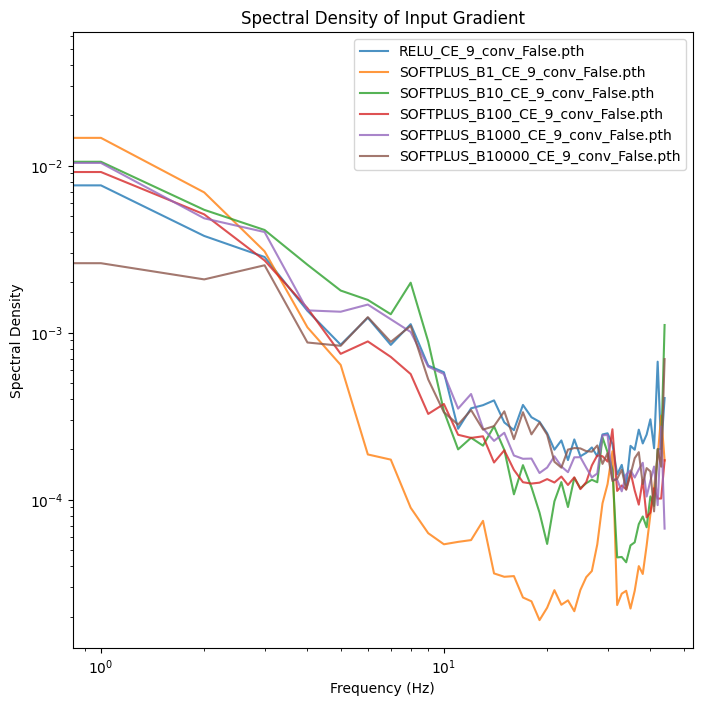

In [7]:
image_idx = 1
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
loss = LossSwitch.CE

# image_spectrum = compute_1d_power_spectrum(raw_image.squeeze())
# plt.plot(image_spectrum[1:]/image_spectrum[1:].sum(),label='original')

plt.figure(figsize=(8, 8))


for activation,epoch,bias in product(activations,[epochs-1],[2]):
    if bias == 2:
        path = "_conv_False"
    elif bias == 1:
        path = "_False"
    elif bias == 0:
        path = ""

    value = True if bias == 2 else False
    conv_bias,fc_bias = (True,True) if bias == 0 else (False,value)

    checkpoint_filename = f'{activation}_{loss}_{epoch}{path}.pth'
    raw_image, label = training_data[image_idx]
    image = raw_image.unsqueeze(0).to(device)
    image.requires_grad = True

    activation_fn = convert_str_to_activation_fn(activation)
    model = NeuralNetwork(activation_fn, conv_bias=conv_bias, fc_bias=fc_bias).to(device)
    checkpoint_path = f'{checkpoint_dir}/{checkpoint_filename}'
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint)
    model.eval()

    output = model(image)
    output.max().backward()
    input_gradient = np.abs(image.grad.detach().cpu().numpy())
    input_gradient = input_gradient/np.max(input_gradient)

    input_gradient = input_gradient.squeeze()
    power_spectrum = compute_1d_power_spectrum(input_gradient)
    # power_spectrum = power_spectrum[1:]
    power_spectrum = power_spectrum/power_spectrum.sum()
    plt.plot(power_spectrum[1:],alpha=0.8,label=checkpoint_filename) # remove constant component for better visualization

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Spectral Density')
plt.title('Spectral Density of Input Gradient')
plt.legend()
plt.show()

## brute force visualization

<ipython-input-10-f6d3c35220ad>:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)


Text(0.5, 1.0, 'input image SOFTPLUS_B10000 CE 9')

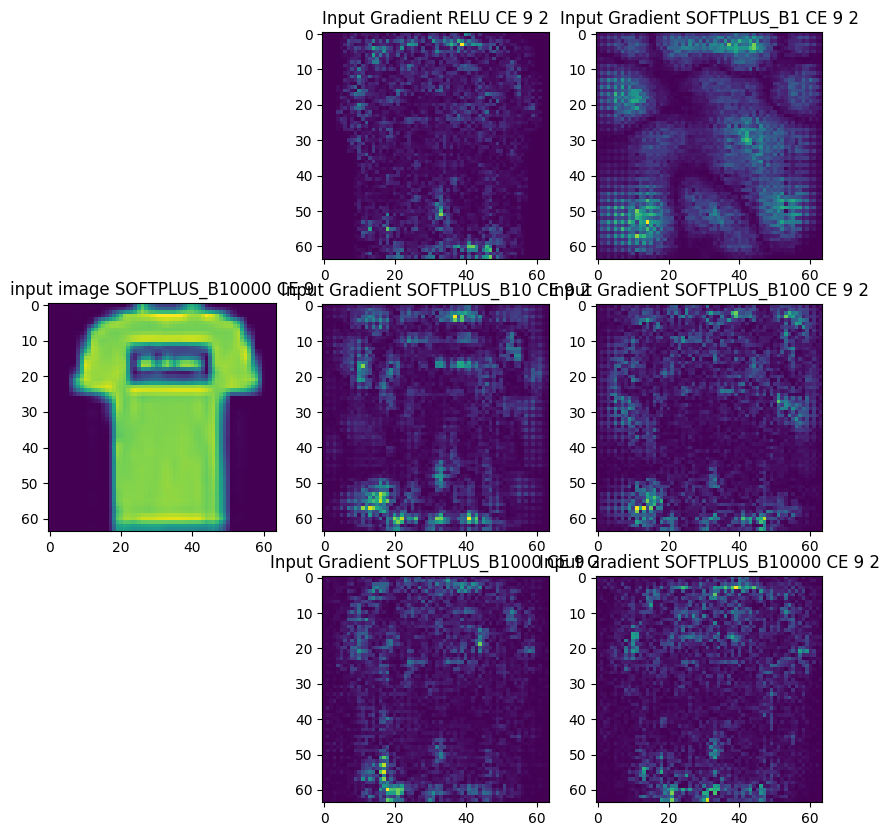

In [10]:
image_idx = 1
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

plt.figure(figsize=(10, 10))
counter = 2
for i,(activation,loss,epoch,bias) in enumerate(product(activations,[LossSwitch.CE],[epochs-1],[2])):

    if bias == 2:
        path = "_conv_False"
    elif bias == 1:
        path = "_False"
    elif bias == 0:
        path = ""
    value = True if bias == 2 else False
    conv_bias,fc_bias = (True,True) if bias == 0 else (False,value)

    checkpoint_filename = f'{activation}_{loss}_{epoch}{path}.pth'

    raw_image, label = training_data[image_idx]
    image = raw_image.unsqueeze(0).to(device)
    image.requires_grad = True

    # Load the model from the checkpoint
    activation_fn = convert_str_to_activation_fn(activation)
    model = NeuralNetwork(activation_fn,conv_bias,fc_bias).to(device)
    checkpoint_path = f'{checkpoint_dir}/{checkpoint_filename}'
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint)
    model.eval()  # Set the model to evaluation mode

    output = model(image)
    output.max().backward()
    input_gradient = np.abs(image.grad.detach().cpu().numpy())
    input_gradient = input_gradient/np.max(input_gradient)
    plt.subplot(3, 3, counter)
    counter += 2 if counter%3 == 0 else 1
    plt.imshow(input_gradient.squeeze())
    plt.title(f'Input Gradient {activation} {loss} {epoch} {bias}')

plt.subplot(1, 3, 1)
plt.imshow(raw_image.squeeze())
plt.title(f'input image {activation} {loss} {epoch}')

<ipython-input-11-e48012fa763e>:28: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)


Text(0.5, 1.0, 'input image SOFTPLUS_B10000 CE 9')

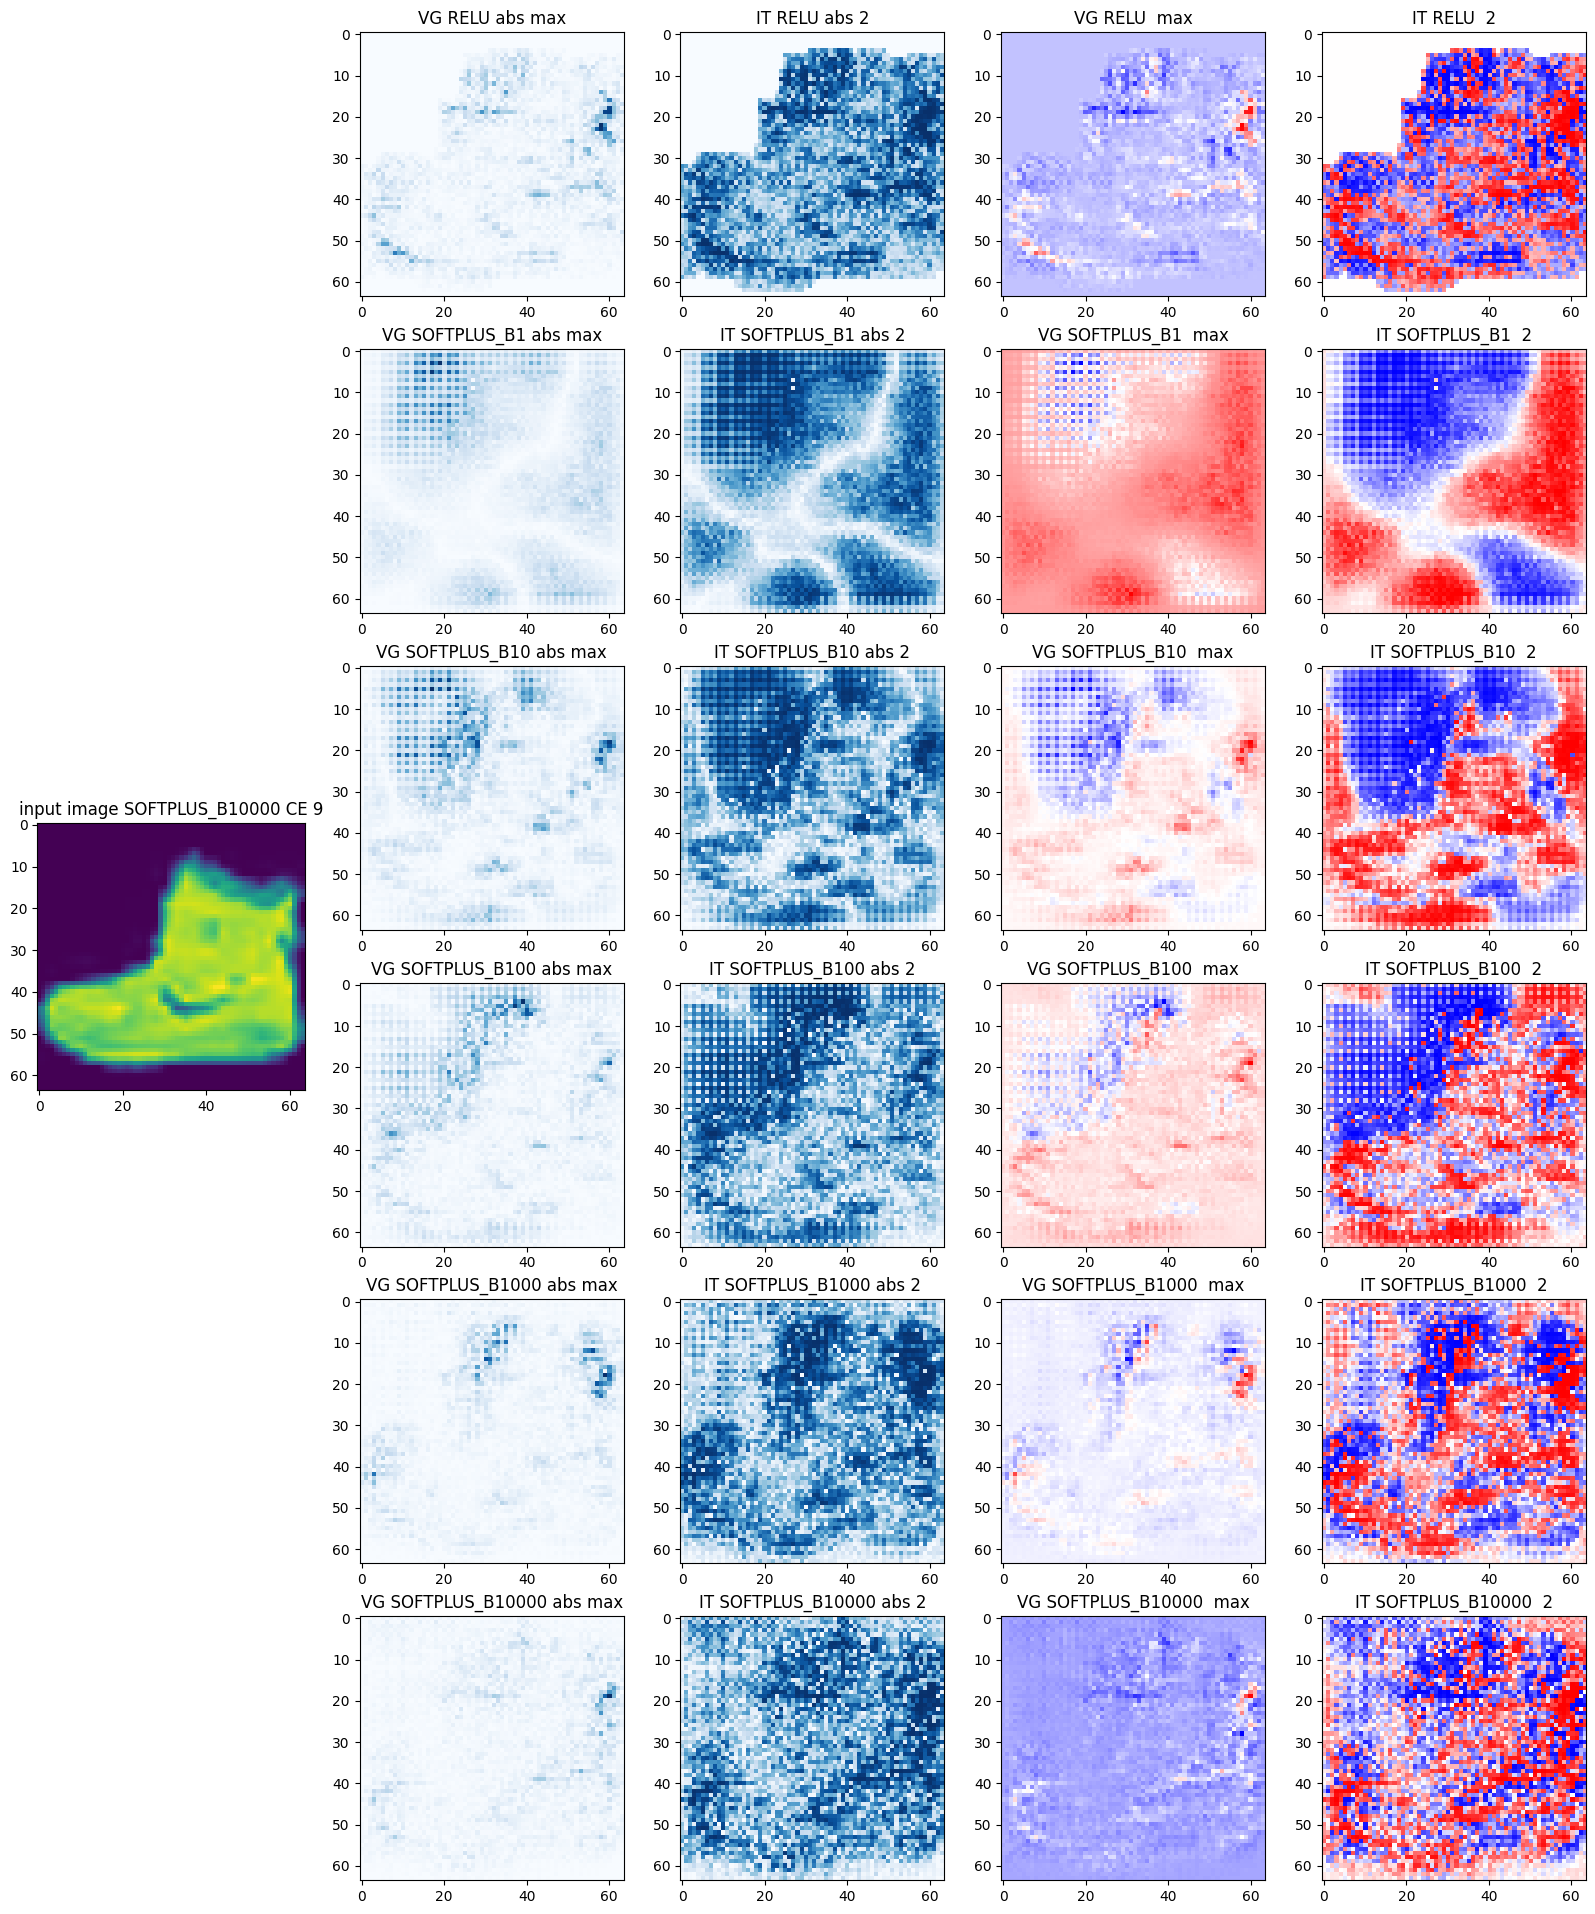

In [11]:
image_idx = 0
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

plt.figure(figsize=(20, 24))
counter = 2
for i,(activation,loss,epoch,bias,j,k) in enumerate(product(activations,[LossSwitch.CE],[epochs-1],[2],range(2),[0])):

    if bias == 2:
        path = "_conv_False"
    elif bias == 1:
        path = "_False"
    elif bias == 0:
        path = ""

    value = True if bias == 2 else False
    conv_bias,fc_bias = (True,True) if bias == 0 else (False,value)

    checkpoint_filename = f'{activation}_{loss}_{epoch}{path}.pth'

    raw_image, label = training_data[image_idx]
    image = raw_image.unsqueeze(0).to(device)
    image.requires_grad = True

    # Load the model from the checkpoint
    activation_fn = convert_str_to_activation_fn(activation)
    model = NeuralNetwork(activation_fn,conv_bias,fc_bias).to(device)
    checkpoint_path = f'{checkpoint_dir}/{checkpoint_filename}'
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint)
    model.eval()  # Set the model to evaluation mode

    output = model(image)
    output = output.max() if k == 0 else output.min()
    output.backward()

    input_gradient = image.grad.detach().cpu().numpy()
    input_gradient = np.abs(input_gradient) if j == 0 else input_gradient
    input_gradient = input_gradient/np.max(input_gradient)

    plt.subplot(6, 5, counter)
    counter += 2 if counter%5 == 0 else 1

    minmax_str = 'max' if k == 0 else 'min'
    abs_str = 'abs' if j == 0 else ''
    cmap = 'Blues' if j == 0 else 'bwr'

    plt.imshow(input_gradient.squeeze(),cmap=cmap)
    plt.title(f'VG {activation} {abs_str} {minmax_str}')


    expected_shape = input_gradient.squeeze().shape
    U = rankdata(input_gradient.flatten()) / (input_gradient.squeeze().shape[0] * input_gradient.squeeze().shape[1])
    U = U.reshape(expected_shape)
    plt.subplot(6, 5, counter)
    counter += 2 if counter%5 == 0 else 1
    # U = np.stack([image.detach().cpu().numpy().squeeze(),U,np.zeros_like(U)],axis=2)
    plt.imshow(U,cmap=cmap)

    plt.title(f'IT {activation} {abs_str} {bias}')

plt.subplot(1, 5, 1)
plt.imshow(raw_image.squeeze())
plt.title(f'input image {activation} {loss} {epoch}')